In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from tabnet_keras import TabNetRegressor, TabNetClassifier
from tensorflow.keras.layers import LayerNormalization, Dropout, Concatenate
from tensorflow.keras import layers

# from tensorflow.keras import regularizers
# from tabnet_keras.models import TabNetClassifier




In [2]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from models.VGG16 import VGG16_1D
from models.InceptionV2 import InceptionV2_1D
from models.InceptionV3 import InceptionV3_1D
# from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection
c:/Users/Admin/Data/ads_fraud_detection


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('Using GPU:', gpus[0])  # In ra tên của GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
else:
    print('No GPU found. Using CPU.')

No GPU found. Using CPU.


In [4]:
save_dir=f"{exps_dir}/exp1/exp_base"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [5]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [6]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [7]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.6555772994129159, 1: 2.106918238993711}

In [8]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse_output=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(330, 2) (670, 2)


In [9]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(330, 2)


In [10]:
x_test.shape

(330, 39)

In [11]:
x_train.shape

(670, 39)

In [12]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [13]:
print(x_train.shape[1])

39


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [14]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [16]:
import tensorflow as tf
focal_loss=tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='categorical_focal_crossentropy'
)

In [17]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.dim = dim
        self.scale = dim ** -0.5

    def call(self, key, query, value):
        attention = tf.matmul(query, key, transpose_b=True) * self.scale
        attention_weights = tf.nn.softmax(attention, axis=-1)
        return tf.matmul(attention_weights, value)

In [18]:
class JointLateFusionModel(tf.keras.Model):
    def __init__(self, model1, model2):
        """
        Khởi tạo JointLateFusionModel.
        :param model1: Mô hình đầu tiên.
        :param model2: Mô hình thứ hai.
        """
        super(JointLateFusionModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.feature_merger = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3)
        ])
        self.output_merger = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(2, activation='softmax')  # 2 là số lớp đầu ra
        ])

    def call(self, input, training=False):
        """
        Logic cho forward pass.
        :param input: Đầu vào chung cho cả hai mô hình.
        :param training: Cờ để bật/tắt dropout khi huấn luyện.
        :return: Dự đoán của mô hình.
        """
        features1 = self.model1(input)  # Đặc trưng từ model1
        features2 = self.model2(input)  # Đặc trưng từ model2
        merged_features = tf.concat([features1, features2], axis=-1)  # Kết hợp đặc trưng
        enhanced_features = self.feature_merger(merged_features, training=training)
        return self.output_merger(enhanced_features, training=training)


In [19]:
l2_reg = 0.01
lr=0.001
dummy_input = tf.zeros((1,  x_train.shape[1]))  # Thay thế input_shape bằng hình dạng của dữ liệu thực tế
# tabnet(dummy_inp ut)
learning_rate=0.1
tabnet_params = {
    "decision_dim": 512,
    "attention_dim": 512,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



tabnet = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)

In [20]:
tabnet.build((None, x_train.shape[1]))

In [21]:
tabnet.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  19145840  
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  1024      
                                                                 
Total params: 19146864 (73.04 MB)
Trainable params: 19081016 (72.79 MB)
Non-trainable params: 65848 (257.22 KB)
_________________________________________________________________


In [22]:
tabnet.load_weights("../weights/model_weights.h5") 

In [23]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = tabnet.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


11/11 [==============================] - 1s 22ms/step


0.7909090909090909

In [24]:
# def tabnet_feature(model,input_shape=(x_train.shape[1]), proba=False):
#     input = Input(shape=input_shape)
#     feature = tabnet.get_layer('tab_net_encoder_1')(input)
#     probability=tabnet.get_layer('classifier')(feature)
#     if proba:
#         output=Concatenate()([feature,probability])
#     else:
#         output=feature
#     model = Model(inputs=input,outputs=[output])
#     return model
# tabnet_model=tabnet_feature(tabnet)
# output=tabnet_model(dummy_input)
# print(output.shape)

In [25]:
vgg16 =VGG16_1D(input_shape=(x_train.shape[1],1), features=False).model
inceptionv2 = InceptionV2_1D(input_shape=(x_train.shape[1],1), features=False).model
inceptionv3 = InceptionV3_1D(input_shape=(x_train.shape[1],1), features=False).model




vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# tabnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
tabnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
inceptionv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
inceptionv3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])

In [26]:
vgg16.load_weights("../weights/vgg1024.h5") 

In [27]:
output=vgg16(dummy_input)
output.shape

TensorShape([1, 2])

In [28]:
output=inceptionv2(dummy_input)
output.shape

TensorShape([1, 2])

In [29]:
output=inceptionv3(dummy_input)
output.shape

TensorShape([1, 10])

In [30]:
# vgg16.fit(x=x_train, y=y_train_onehot,
#           validation_data=(x_test, y_test_onehot),
#           batch_size=32,
#           epochs=15,
#           class_weight=class_weights_dict
#           )
# tabnet.fit(x=x_train, y=y_train_onehot,
# tabnet_modelvalidation_data=(x_test, y_test_onehot),
#           batch_size=32,
#           epochs=15,
#           class_weight=class_weights_dict
#           )
# inceptionv2.fit(x=x_train, y=y_train_onehot,
#           validation_data=(x_test, y_test_onehot),
#           batch_size=32,
#           epochs=15,
#           class_weight=class_weights_dict
#           )
# inceptionv3.fit(x=x_train, y=y_train_onehot,
#           validation_data=(x_test, y_test_onehot),
#           batch_size=32,
#           epochs=15,
#           class_weight=class_weights_dict
#           )

In [31]:
input_dim = x_train.shape[1]
model = JointLateFusionModel(model1=vgg16, model2=tabnet)
# model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_f1_score',  # Theo dõi val_f1_score
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_f1_score tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



In [32]:
model.build((None, x_train.shape[1]))

In [33]:
model.summary()

Model: "joint_late_fusion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_1d (Functional)       (None, 2)                 19622530  
                                                                 
 tab_net_classifier (TabNet  multiple                  19146864  
 Classifier)                                                     
                                                                 
 sequential (Sequential)     (None, 64)                320       
                                                                 
 sequential_1 (Sequential)   (None, 2)                 8578      
                                                                 
Total params: 38778292 (147.93 MB)
Trainable params: 38712444 (147.68 MB)
Non-trainable params: 65848 (257.22 KB)
_________________________________________________________________


In [34]:
class_weights_dict

{0: 0.6555772994129159, 1: 2.106918238993711}

In [35]:
model.fit(x=x_train, y=y_train_onehot,
          validation_data=(x_test, y_test_onehot),
          batch_size=32,
          epochs=1200,
          callbacks=[early_stopping, lr_scheduler],
          )

Epoch 1/1200
21/21 [==============================] - 49s 561ms/step - loss: 0.5727 - accuracy: 0.7478 - f1_score: 0.4336 - val_loss: 0.5505 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 0.0010
Epoch 2/1200
21/21 [==============================] - 11s 526ms/step - loss: 0.5302 - accuracy: 0.7627 - f1_score: 0.4316 - val_loss: 0.5205 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 0.0010
Epoch 3/1200
21/21 [==============================] - 11s 544ms/step - loss: 0.5031 - accuracy: 0.7627 - f1_score: 0.4318 - val_loss: 0.4937 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 0.0010
Epoch 4/1200
21/21 [==============================] - 11s 527ms/step - loss: 0.4935 - accuracy: 0.7552 - f1_score: 0.4465 - val_loss: 0.4853 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 0.0010
Epoch 5/1200
21/21 [==============================] - 10s 486ms/step - loss: 0.4799 - accuracy: 0.7627 - f1_score: 0.4590 - val_loss: 0.4821 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 0.0010


In [36]:
model.summary()

Model: "joint_late_fusion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_1d (Functional)       (None, 2)                 19622530  
                                                                 
 tab_net_classifier (TabNet  multiple                  19146864  
 Classifier)                                                     
                                                                 
 sequential (Sequential)     (None, 64)                320       
                                                                 
 sequential_1 (Sequential)   (None, 2)                 8578      
                                                                 
Total params: 38778292 (147.93 MB)
Trainable params: 38712444 (147.68 MB)
Non-trainable params: 65848 (257.22 KB)
_________________________________________________________________


#### * Kết quả đánh giá mô hình:

In [37]:
model.summary()

Model: "joint_late_fusion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_1d (Functional)       (None, 2)                 19622530  
                                                                 
 tab_net_classifier (TabNet  multiple                  19146864  
 Classifier)                                                     
                                                                 
 sequential (Sequential)     (None, 64)                320       
                                                                 
 sequential_1 (Sequential)   (None, 2)                 8578      
                                                                 
Total params: 38778292 (147.93 MB)
Trainable params: 38712444 (147.68 MB)
Non-trainable params: 65848 (257.22 KB)
_________________________________________________________________


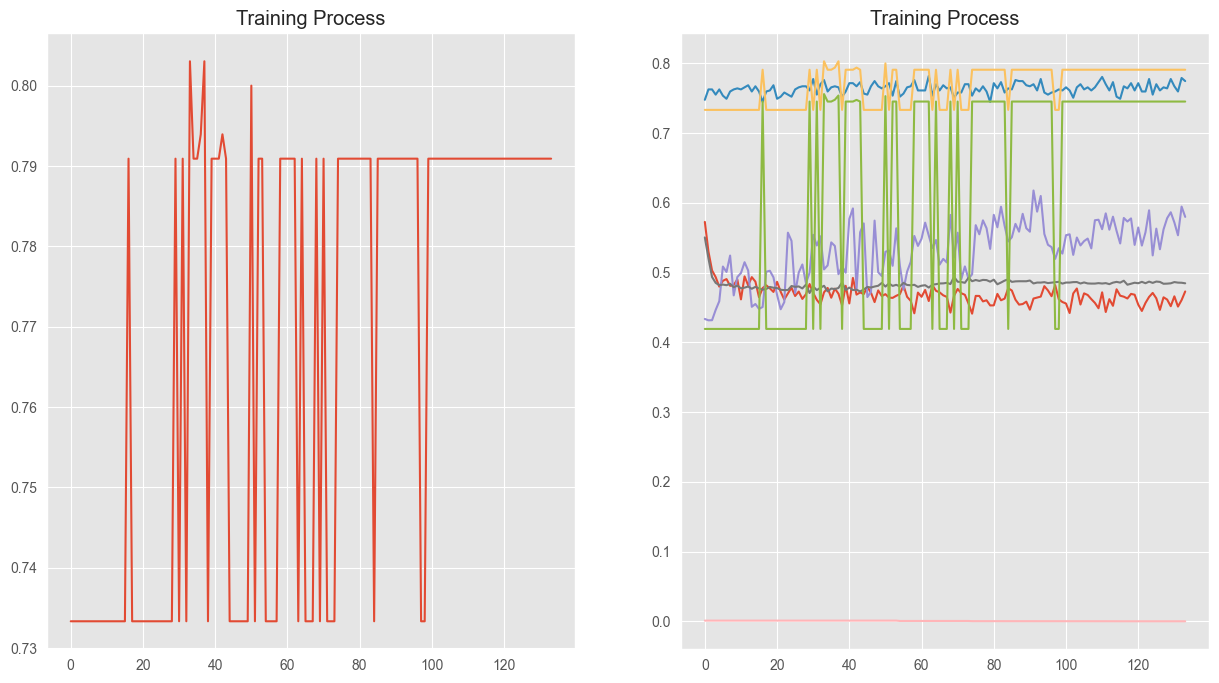

<Figure size 640x480 with 0 Axes>

In [38]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [39]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


11/11 [==============================] - 1s 25ms/step


0.803030303030303

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.803030303030303
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       242
           1       0.62      0.67      0.64        88

    accuracy                           0.80       330
   macro avg       0.75      0.76      0.75       330
weighted avg       0.81      0.80      0.81       330

Confusion Matrix:
[[206  36]
 [ 29  59]]


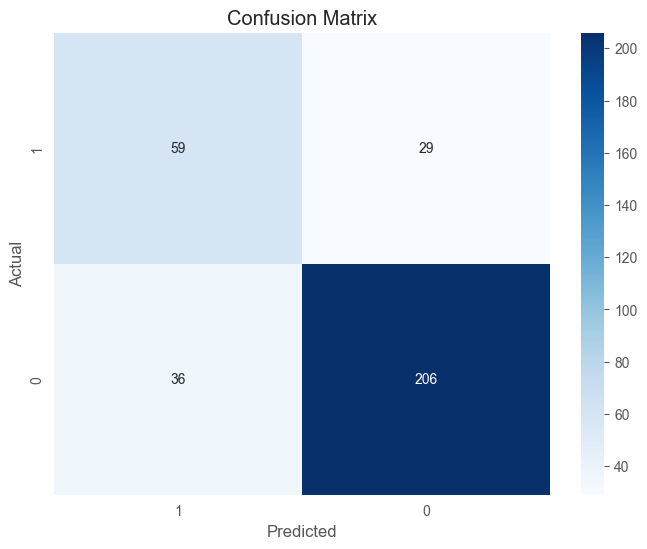

In [41]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

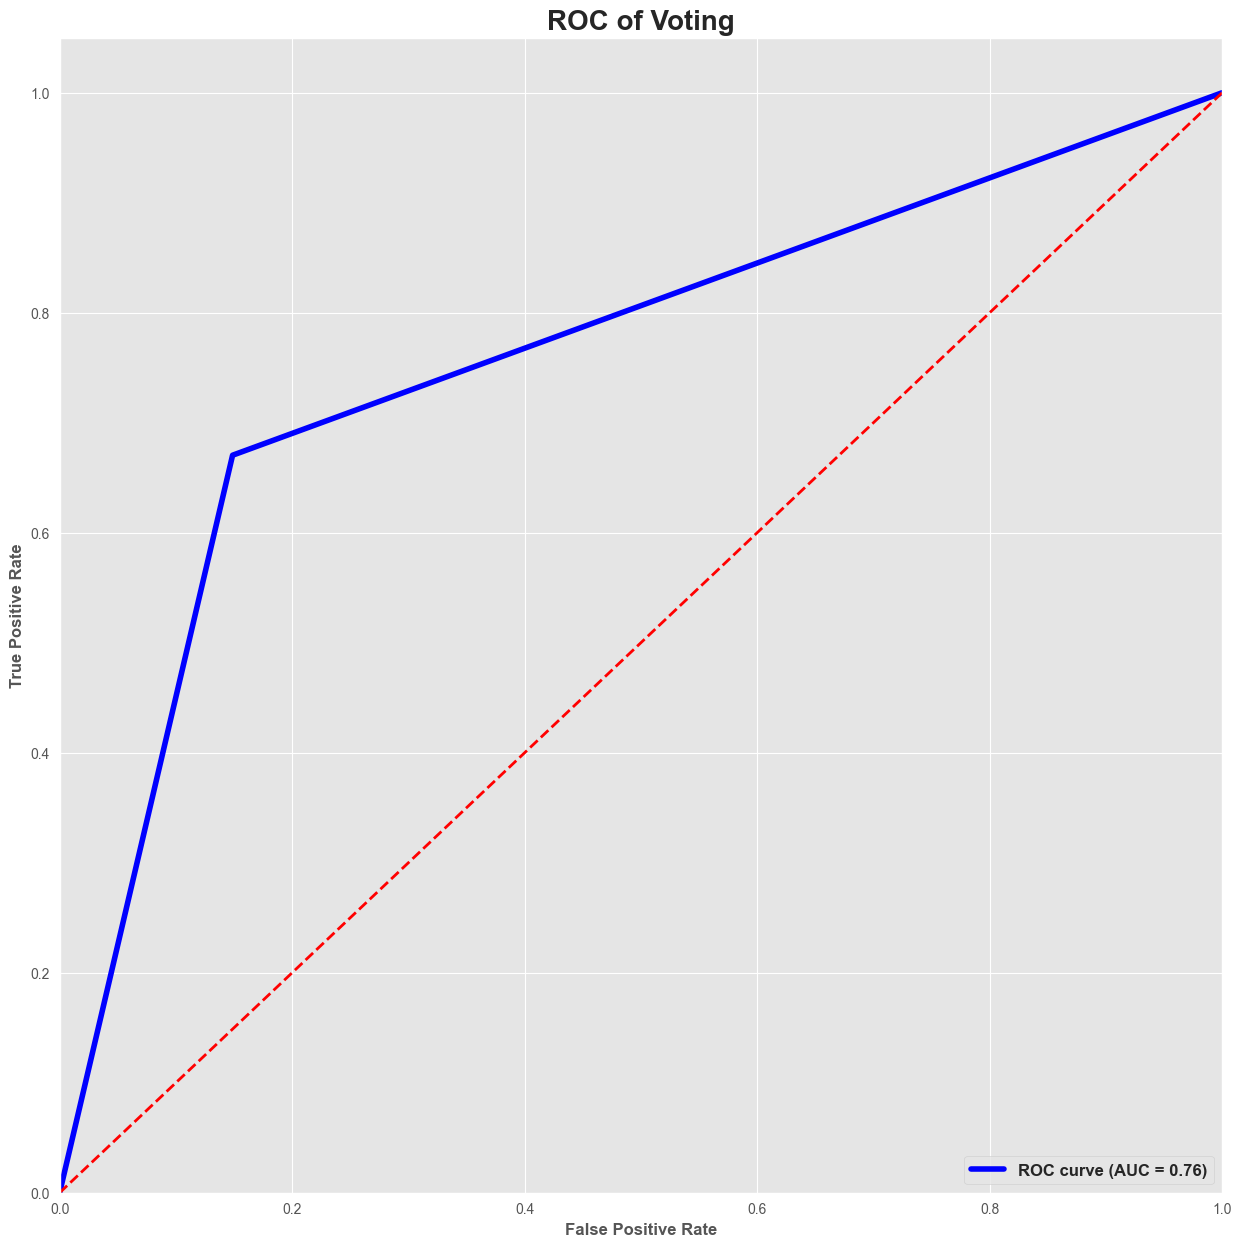

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [43]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [44]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    